In [1]:
import pandas as pd
import requests
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from scipy.stats import norm
from scipy.stats import t
import seaborn as sns
import matplotlib.dates as mdates
import os


Correlation Analysis between MicroStrategy Stock and Bitcoin
In this analysis, we will investigate the potential correlation between MicroStrategy stock price and Bitcoin price over the past year, as well as other Bitcoin ETFs such as FBTC. We will also include a few other stocks as a control group to account for overall market fluctuations, and another company similar to MicroStrategy in terms of market cap and business structure, but does not hold Bitcoin.

Data Collection
Identify and provide links to reliable sources of historical price data for MicroStrategy stock, Bitcoin, FBTC, and the control stocks.
Provide a Python script or Jupyter notebook to scrape or download the data from the identified sources.
Data Cleaning and Preparation
Provide a Python script or Jupyter notebook to clean and preprocess the data, including handling missing values, outliers, and any necessary data transformations.
Provide code to calculate the daily percentage change in price for each asset.
Correlation Analysis
Provide a Python script or Jupyter notebook to calculate the correlation coefficient between MicroStrategy stock price and Bitcoin price, as well as the other assets.
Visualize the correlation matrix using a heatmap.
Statistical Testing
Provide a Python script or Jupyter notebook to perform statistical tests (e.g. Pearson's correlation, Spearman's rank correlation) to determine if the correlation is statistically significant.
Visualization
Provide a Python script or Jupyter notebook to create visualizations of the data, including:
Line charts of the price data for each asset over time.
Scatter plots of MicroStrategy stock price vs. Bitcoin price, as well as the other assets.
A heatmap of the correlation matrix.
Report Generation
Provide a Python script or Jupyter notebook to generate a report summarizing the findings, including the correlation coefficients, statistical test results, and visualizations.

In [2]:
def get_data_yahoo(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

def get_data_coingecko(coin_id, start_date, end_date):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range'
    params = {
        'vs_currency': 'usd',
        'from': int(pd.Timestamp(start_date).timestamp()),
        'to': int(pd.Timestamp(end_date).timestamp())
    }
    response = requests.get(url, params=params)
    data = response.json()
    prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
    prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit='ms')
    prices.set_index('timestamp', inplace=True)
    prices.rename(columns={'price': 'Price'}, inplace=True)
    return prices

# Example usage
start_date = '2023-05-15'
end_date = '2024-05-15'

mstr_data = get_data_yahoo('MSTR', start_date, end_date)
btc_data = get_data_coingecko('bitcoin', start_date, end_date)
fbtc_data = get_data_yahoo('FBTC', start_date, end_date)
pltr_data = get_data_yahoo('PLTR', start_date, end_date)
# Save data to CSV files
mstr_data.to_csv('mstr_data.csv')
btc_data.to_csv('btc_data.csv')
fbtc_data.to_csv('fbtc_data.csv')
pltr_data.to_csv('pltr_data.csv')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
def get_csv_columns(directory):
    def get_column_names_and_types(file_path):
        data = pd.read_csv(file_path, nrows=0)  # Read just the header
        column_names = data.columns.tolist()
        column_types = data.dtypes.to_dict()
        return column_names, column_types

    # List all CSV files in the directory
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

    # Loop through each CSV file
    for file in csv_files:
        file_path = os.path.join(directory, file)
        
        # Get column names and types
        column_names, column_types = get_column_names_and_types(file_path)
        
        # Print the column names and types
        print(f"Column names for {file}: {column_names}")
        print(f"Column types for {file}: {column_types}")
        print()  # Add a blank line for better readability

# Define the directory containing CSV files
directory = r"C:\Users\qaism\OneDrive - University of Virginia\Documents\GitHub\Microstrategy_Bitcoin"

# Call the function
get_csv_columns(directory)


Column names for btc_data.csv: ['timestamp', 'Price']
Column types for btc_data.csv: {'timestamp': dtype('O'), 'Price': dtype('O')}

Column names for btc_data_clean.csv: ['timestamp', 'Price', 'Pct_Change']
Column types for btc_data_clean.csv: {'timestamp': dtype('O'), 'Price': dtype('O'), 'Pct_Change': dtype('O')}

Column names for fbtc_data.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Column types for fbtc_data.csv: {'Date': dtype('O'), 'Open': dtype('O'), 'High': dtype('O'), 'Low': dtype('O'), 'Close': dtype('O'), 'Adj Close': dtype('O'), 'Volume': dtype('O')}

Column names for fbtc_data_clean.csv: ['Date', 'Price', 'Pct_Change']
Column types for fbtc_data_clean.csv: {'Date': dtype('O'), 'Price': dtype('O'), 'Pct_Change': dtype('O')}

Column names for mstr_data.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Column types for mstr_data.csv: {'Date': dtype('O'), 'Open': dtype('O'), 'High': dtype('O'), 'Low': dtype('O'), 'Close': dtype('O'),

In [4]:
def clean_data(file_path, source='yahoo'):
    if source == 'coingecko':
        data = pd.read_csv(file_path)
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data.set_index('timestamp', inplace=True)
        data = data.rename(columns={'Price': 'Price'})
    else:
        data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
        data = data[['Adj Close']].rename(columns={'Adj Close': 'Price'})
    
    data['Price'] = data['Price'].astype(float)
    data['Price'] = data['Price'].ffill().bfill()  # Fill missing values
    return data

def calculate_daily_pct_change(data):
    data['Pct_Change'] = data['Price'].pct_change() * 100
    data.dropna(inplace=True)
    return data

# Example usage
mstr_data = clean_data('mstr_data.csv', source='yahoo')
btc_data = clean_data('btc_data.csv', source='coingecko')
fbtc_data = clean_data('fbtc_data.csv', source='yahoo')
pltr_data = clean_data('pltr_data.csv', source='yahoo')

mstr_data = calculate_daily_pct_change(mstr_data)
btc_data = calculate_daily_pct_change(btc_data)
fbtc_data = calculate_daily_pct_change(fbtc_data)
pltr_data = calculate_daily_pct_change(pltr_data)

# Save cleaned data
mstr_data.to_csv('mstr_data_clean.csv')
btc_data.to_csv('btc_data_clean.csv')
fbtc_data.to_csv('fbtc_data_clean.csv')
pltr_data.to_csv('pltr_data_clean.csv')

          MSTR       BTC      FBTC      PLTR
MSTR  1.000000 -0.082620  0.816190  0.239544
BTC  -0.082620  1.000000 -0.052744 -0.020591
FBTC  0.816190 -0.052744  1.000000  0.232023
PLTR  0.239544 -0.020591  0.232023  1.000000


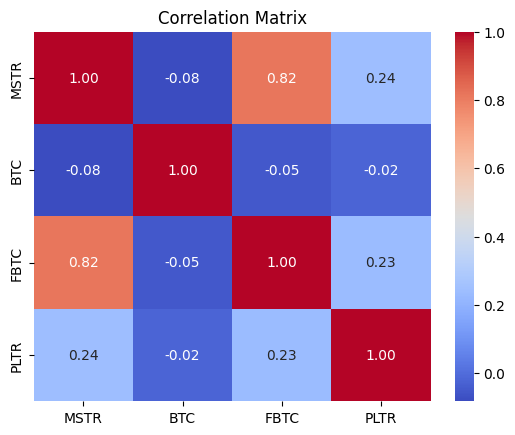

In [5]:
def calculate_correlation(*args):
    data = pd.concat(args, axis=1, join='inner')
    correlation_matrix = data.corr()
    return correlation_matrix

# Load cleaned data
mstr_data = pd.read_csv('mstr_data_clean.csv', index_col='Date', parse_dates=True)
btc_data = pd.read_csv('btc_data_clean.csv', index_col='timestamp', parse_dates=True)
fbtc_data = pd.read_csv('fbtc_data_clean.csv', index_col='Date', parse_dates=True)
pltr_data = pd.read_csv('pltr_data_clean.csv', index_col='Date', parse_dates=True)

# Ensure all percentage change columns are correctly aligned
combined_data = pd.concat([mstr_data['Pct_Change'], btc_data['Pct_Change'], fbtc_data['Pct_Change'], pltr_data['Pct_Change']], axis=1, join='inner')
combined_data.columns = ['MSTR', 'BTC', 'FBTC', 'PLTR']

# Calculate correlation
correlation_matrix = combined_data.corr()
print(correlation_matrix)

# Visualize correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [6]:
from scipy import stats
def perform_statistical_tests(data):
    results = {}
    pairs = [('MSTR', 'BTC'), ('MSTR', 'FBTC'), ('MSTR', 'PLTR')]
    
    for x, y in pairs:
        pearson_corr, pearson_p = stats.pearsonr(data[x], data[y])
        spearman_corr, spearman_p = stats.spearmanr(data[x], data[y])
        results[f'{x} vs {y}'] = {
            'Pearson Correlation': pearson_corr,
            'Pearson P-Value': pearson_p,
            'Spearman Correlation': spearman_corr,
            'Spearman P-Value': spearman_p
        }
    return results

# Perform statistical tests
test_results = perform_statistical_tests(combined_data)
print(test_results)

{'MSTR vs BTC': {'Pearson Correlation': -0.08261962820858605, 'Pearson P-Value': 0.4522172899696169, 'Spearman Correlation': 0.002501465702560094, 'Spearman P-Value': 0.9818728766222746}, 'MSTR vs FBTC': {'Pearson Correlation': 0.8161901775251313, 'Pearson P-Value': 1.791733619868362e-21, 'Spearman Correlation': 0.7918702364666796, 'Spearman P-Value': 1.8303796981436483e-19}, 'MSTR vs PLTR': {'Pearson Correlation': 0.23954412313996376, 'Pearson P-Value': 0.027241333116590077, 'Spearman Correlation': 0.3892905999609146, 'Spearman P-Value': 0.0002311200121528598}}


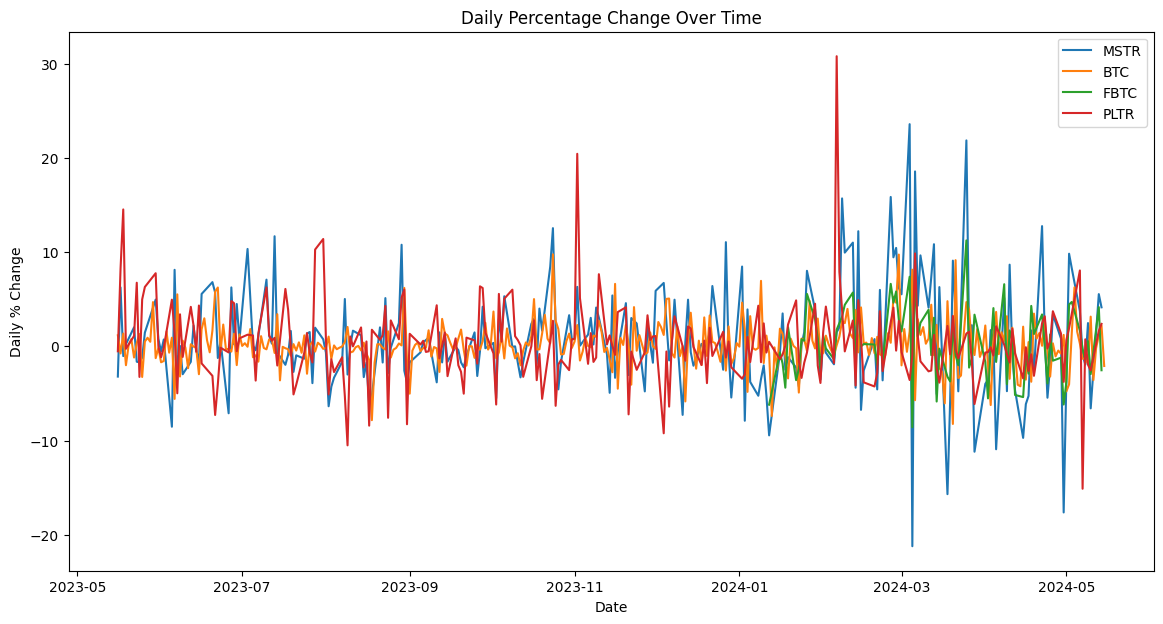

In [7]:
# Line charts of the daily percentage change over time
def plot_pct_change_data(*args, labels):
    plt.figure(figsize=(14, 7))
    for data, label in zip(args, labels):
        plt.plot(data.index, data['Pct_Change'], label=label)
    plt.xlabel('Date')
    plt.ylabel('Daily % Change')
    plt.title('Daily Percentage Change Over Time')
    plt.legend()
    plt.show()

# Scatter plots of daily percentage change for pairs of assets
def plot_scatter(data, x, y):
    plt.figure(figsize=(7, 7))
    plt.scatter(data[x], data[y], alpha=0.5)
    plt.xlabel(f'{x} Daily % Change')
    plt.ylabel(f'{y} Daily % Change')
    plt.title(f'{x} vs. {y}')
    plt.show()

# Load cleaned data
mstr_data = pd.read_csv('mstr_data_clean.csv', index_col='Date', parse_dates=True)
btc_data = pd.read_csv('btc_data_clean.csv', index_col='timestamp', parse_dates=True)
fbtc_data = pd.read_csv('fbtc_data_clean.csv', index_col='Date', parse_dates=True)
pltr_data = pd.read_csv('pltr_data_clean.csv', index_col='Date', parse_dates=True)

# Plot percentage change data over time
plot_pct_change_data(mstr_data, btc_data, fbtc_data, pltr_data, labels=['MSTR', 'BTC', 'FBTC', 'PLTR'])

# Ensure all percentage change columns are correctly aligned
combined_data = pd.concat([mstr_data['Pct_Change'], btc_data['Pct_Change'], fbtc_data['Pct_Change'], pltr_data['Pct_Change']], axis=1, join='inner')
combined_data.columns = ['MSTR', 'BTC', 'FBTC', 'PLTR']


In [8]:
import requests
import pandas as pd
from pycoingecko import CoinGeckoAPI

def get_data_yahoo(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

def get_data_coingecko_ohlc(coin_id, vs_currency, days):
    cg = CoinGeckoAPI()
    ohlc = cg.get_coin_ohlc_by_id(id=coin_id, vs_currency=vs_currency, days=days)
    
    if not ohlc:
        raise ValueError(f"No OHLC data returned for {coin_id} over {days} days")
    
    # Convert to DataFrame
    df = pd.DataFrame(ohlc, columns=['date', 'open', 'high', 'low', 'close'])
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    df.set_index('date', inplace=True)
    
    return df

# Example usage
start_date = '2023-05-01'
end_date = '2024-05-01'

try:
    mstr_data = get_data_yahoo('MSTR', start_date, end_date)
    btc_data = get_data_coingecko_ohlc('bitcoin', 'usd', 365)
    
    print("MSTR Data:")
    print(mstr_data.head())
    
    print("\nBTC OHLC Data:")
    print(btc_data.head())
    
except Exception as e:
    print(f"Error: {e}")


[*********************100%%**********************]  1 of 1 completed


MSTR Data:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-01  320.000000  323.359985  304.239990  307.470001  307.470001   
2023-05-02  310.140015  332.929993  305.130005  328.010010  328.010010   
2023-05-03  320.489990  321.890015  301.679993  304.250000  304.250000   
2023-05-04  311.149994  321.190002  307.500000  312.239990  312.239990   
2023-05-05  313.000000  328.720001  312.000000  326.720001  326.720001   

             Volume  
Date                 
2023-05-01   905500  
2023-05-02  1373300  
2023-05-03  1193000  
2023-05-04   715100  
2023-05-05   907900  

BTC OHLC Data:
               open     high      low    close
date                                          
2023-05-15  26783.0  27148.0  26704.0  26912.0
2023-05-19  26933.0  27642.0  26517.0  26843.0
2023-05-23  26847.0  27261.0  26543.0  26870.0
2023-05-27  26863.0  27420.0  25887.0  26718.0
2023-05-31  26719.

In [9]:
def clean_data(file_path, source='yahoo'):
    if source == 'coingecko':
        data = pd.read_csv(file_path)
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data.set_index('timestamp', inplace=True)
        data = data.rename(columns={'Price': 'Price'})
    else:
        data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
        data = data[['Adj Close']].rename(columns={'Adj Close': 'Price'})
    
    data['Price'] = data['Price'].astype(float)
    data['Price'] = data['Price'].ffill().bfill()  # Fill missing values
    return data

def calculate_daily_pct_change(data):
    data['Pct_Change'] = data['Price'].pct_change() * 100
    data.dropna(inplace=True)
    return data

# Load and clean data
mstr_data = clean_data('mstr_data.csv', source='yahoo')
btc_data = clean_data('btc_data.csv', source='coingecko')

# Calculate daily percentage changes
mstr_data = calculate_daily_pct_change(mstr_data)
btc_data = calculate_daily_pct_change(btc_data)

# Save cleaned data
mstr_data.to_csv('mstr_data_clean.csv')
btc_data.to_csv('btc_data_clean.csv')


In [10]:
# Identify days with highest positive and negative percentage changes in BTC
top_positive_days = btc_data.nlargest(5, 'Pct_Change')
top_negative_days = btc_data.nsmallest(5, 'Pct_Change')

print("Top 5 Positive BTC Days:\n", top_positive_days)
print("Top 5 Negative BTC Days:\n", top_negative_days)

Top 5 Positive BTC Days:
                    Price  Pct_Change
timestamp                           
2023-10-24  32953.262761    9.773294
2024-02-29  62558.582024    9.745108
2024-03-21  67819.055707    9.152274
2024-03-05  68186.645934    8.141614
2024-01-09  46936.185561    6.955746
Top 5 Negative BTC Days:
                    Price  Pct_Change
timestamp                           
2024-03-20  62132.517379   -8.235878
2023-08-18  26501.587270   -7.834021
2024-01-13  42893.929606   -7.385239
2024-04-03  65440.419226   -6.226909
2024-03-17  65292.313293   -6.051202


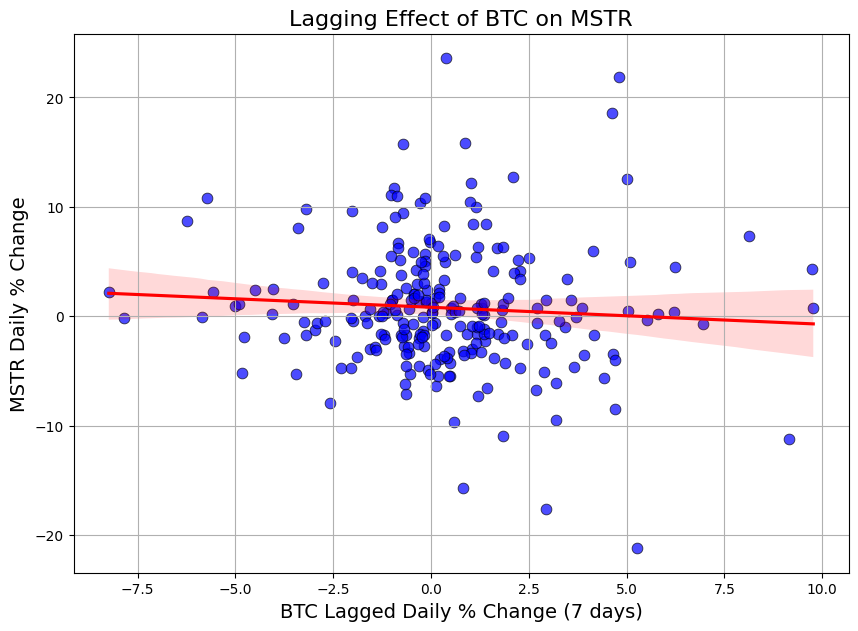

Correlation Matrix with Lagging Effect:
             BTC_Lagged      MSTR
BTC_Lagged    1.000000 -0.072939
MSTR         -0.072939  1.000000


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_lagging_effect(btc_data, mstr_data, lag_days):
    # Shift BTC percentage changes to create a lagging effect
    btc_data['Lagged_Pct_Change'] = btc_data['Pct_Change'].shift(lag_days)
    combined_data = pd.concat([btc_data['Lagged_Pct_Change'], mstr_data['Pct_Change']], axis=1, join='inner')
    combined_data.columns = ['BTC_Lagged', 'MSTR']
    
    return combined_data

# Analyze lagging effect with 1-week (7 days) lag
lag_days = 7
lagged_data = analyze_lagging_effect(btc_data, mstr_data, lag_days)

# Plot the lagging effect with improvements
plt.figure(figsize=(10, 7))
sns.scatterplot(data=lagged_data, x='BTC_Lagged', y='MSTR', s=60, color='blue', edgecolor='black', alpha=0.7)
sns.regplot(data=lagged_data, x='BTC_Lagged', y='MSTR', scatter=False, color='red')
plt.xlabel('BTC Lagged Daily % Change (7 days)', fontsize=14)
plt.ylabel('MSTR Daily % Change', fontsize=14)
plt.title('Lagging Effect of BTC on MSTR', fontsize=16)
plt.grid(True)
plt.show()

# Calculate correlation for lagging effect
correlation_lagged = lagged_data.corr()
print("Correlation Matrix with Lagging Effect:\n", correlation_lagged)


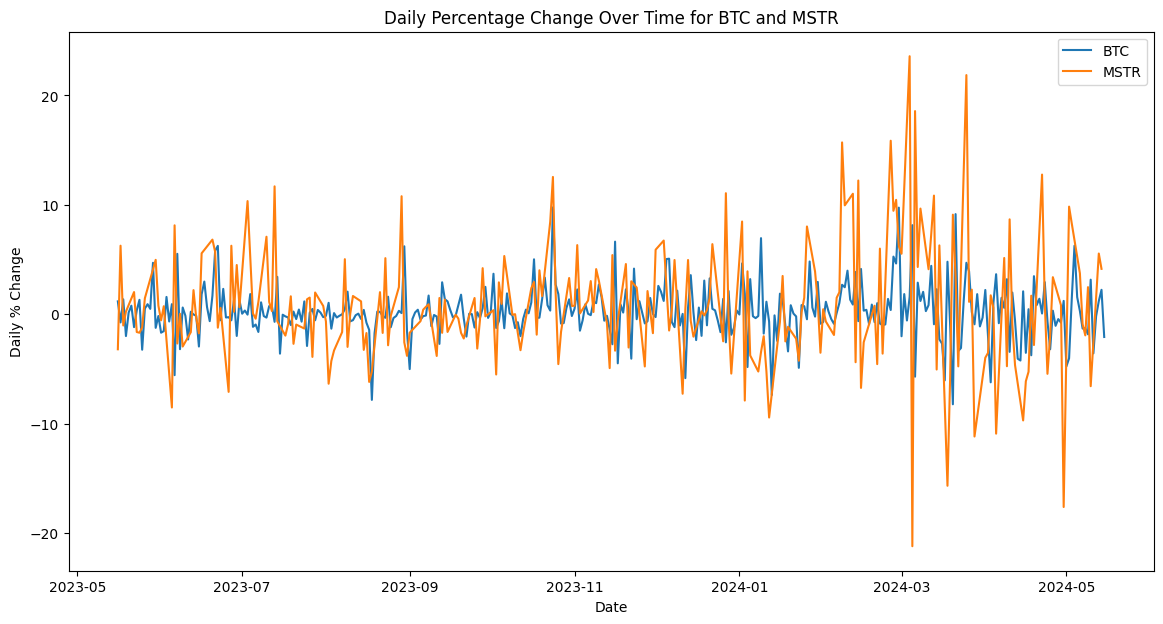

In [12]:
# Plotting BTC and MSTR percentage changes over time
def plot_pct_change_data(btc_data, mstr_data):
    plt.figure(figsize=(14, 7))
    plt.plot(btc_data.index, btc_data['Pct_Change'], label='BTC')
    plt.plot(mstr_data.index, mstr_data['Pct_Change'], label='MSTR')
    plt.xlabel('Date')
    plt.ylabel('Daily % Change')
    plt.title('Daily Percentage Change Over Time for BTC and MSTR')
    plt.legend()
    plt.show()

plot_pct_change_data(btc_data, mstr_data)

In [13]:
import pandas as pd
import yfinance as yf

def get_data_yahoo(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Pct_Change'] = data['Adj Close'].pct_change() * 100
    data.dropna(inplace=True)
    return data

# Example usage
start_date = '2023-05-01'
end_date = '2024-05-01'

mstr_data = get_data_yahoo('MSTR', start_date, end_date)
spx_data = get_data_yahoo('^GSPC', start_date, end_date)

# Read cleaned BTC data
btc_data = pd.read_csv('btc_data_clean.csv', index_col='timestamp', parse_dates=True)

# Verify data
print("MSTR Data:\n", mstr_data.head())
print("SPX Data:\n", spx_data.head())
print("BTC Data:\n", btc_data.head())

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed

MSTR Data:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-02  310.140015  332.929993  305.130005  328.010010  328.010010   
2023-05-03  320.489990  321.890015  301.679993  304.250000  304.250000   
2023-05-04  311.149994  321.190002  307.500000  312.239990  312.239990   
2023-05-05  313.000000  328.720001  312.000000  326.720001  326.720001   
2023-05-08  311.149994  311.750000  294.000000  294.670013  294.670013   

             Volume  Pct_Change  
Date                             
2023-05-02  1373300    6.680329  
2023-05-03  1193000   -7.243684  
2023-05-04   715100    2.626127  
2023-05-05   907900    4.637462  
2023-05-08  1043000   -9.809619  
SPX Data:
                    Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-05-02  4164.100098  4164.100098  4089.719971  4119.580078

In [14]:
# Identify days with highest positive and negative percentage changes in BTC
top_positive_days = btc_data.nlargest(5, 'Pct_Change')
top_negative_days = btc_data.nsmallest(5, 'Pct_Change')

print("Top 5 Positive BTC Days:\n", top_positive_days)
print("Top 5 Negative BTC Days:\n", top_negative_days)

Top 5 Positive BTC Days:
                    Price  Pct_Change
timestamp                           
2023-10-24  32953.262761    9.773294
2024-02-29  62558.582024    9.745108
2024-03-21  67819.055707    9.152274
2024-03-05  68186.645934    8.141614
2024-01-09  46936.185561    6.955746
Top 5 Negative BTC Days:
                    Price  Pct_Change
timestamp                           
2024-03-20  62132.517379   -8.235878
2023-08-18  26501.587270   -7.834021
2024-01-13  42893.929606   -7.385239
2024-04-03  65440.419226   -6.226909
2024-03-17  65292.313293   -6.051202


In [15]:
# Merge data to focus on significant days
def merge_data(significant_days, mstr_data, spx_data):
    significant_days = significant_days.index
    mstr_changes = mstr_data.loc[significant_days]
    spx_changes = spx_data.loc[significant_days]
    
    combined_data = pd.DataFrame({
        'BTC_Pct_Change': btc_data.loc[significant_days, 'Pct_Change'],
        'MSTR_Pct_Change': mstr_changes['Pct_Change'],
        'SPX_Pct_Change': spx_changes['Pct_Change']
    })
    return combined_data

top_positive_combined = merge_data(top_positive_days, mstr_data, spx_data)
top_negative_combined = merge_data(top_negative_days, mstr_data, spx_data)

print("Combined Data for Top Positive BTC Days:\n", top_positive_combined)
print("Combined Data for Top Negative BTC Days:\n", top_negative_combined)

KeyError: "[Timestamp('2024-01-13 00:00:00'), Timestamp('2024-03-17 00:00:00')] not in index"

In [ ]:
import matplotlib.pyplot as plt

def plot_comparison(data, title):
    data.plot(kind='bar', figsize=(10, 7))
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Percentage Change')
    plt.grid(True)
    plt.show()

# Plot the comparison for top positive and negative BTC days
plot_comparison(top_positive_combined, 'Comparison on Top Positive BTC Days')
plot_comparison(top_negative_combined, 'Comparison on Top Negative BTC Days')

In [ ]:
from fpdf import FPDF

class PDFReport(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Correlation Analysis Report', 0, 1, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

    def add_image(self, image_path):
        self.image(image_path, w=180)
        self.ln(10)

# Generate report
pdf = PDFReport()
pdf.add_page()
pdf.chapter_title('Introduction')
pdf.chapter_body('This report investigates the potential correlation between MicroStrategy stock price and Bitcoin price over the past year, including analysis of other Bitcoin ETFs and control stocks.')

pdf.chapter_title('Correlation Matrix')
pdf.add_image('correlation_matrix.png')  # Save the heatmap as 'correlation_matrix.png'

pdf.chapter_title('Statistical Test Results')
test_results_text = f"""
Pearson Correlation: {test_results['Pearson Correlation']}
Pearson P-Value: {test_results['Pearson P-Value']}
Spearman Correlation: {test_results['Spearman Correlation']}
Spearman P-Value: {test_results['Spearman P-Value']}
"""
pdf.chapter_body(test_results_text)

pdf.chapter_title('Visualizations')
# Save visualizations as images and add them to the report
pdf.add_image('price_data.png')
pdf.add_image('scatter_mstr_btc.png')
pdf.add_image('scatter_mstr_fbtc.png')
pdf.add_image('scatter_mstr_pltr.png')

pdf.output('correlation_analysis_report.pdf')